In [4]:
library(tidyverse)
library(repr)
library(tidymodels)
library(rvest)
library(stringr)
library(DBI)
library(dbplyr)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

# < Insert Title here >

# Introduction
### Background 

Tennis is a popular, competitive sport played around the world. In tennis, players gain points by hitting a tennis ball, across a net in the court, in such a way that their opponent is unable to hit it back without the ball bouncing twice. 

Tennis can be played in "singles" where there is only one person on each side of the net or "doubles" where there are teams of two. 
It can be played on a variety of surfaces such as grass, clay, or hard court (i.e. like a gym floor)

- Professional tennis players participate in large **tournaments** for ranks, prizes, and fame. 
- In a tournament, players advance to the next round by winning their **match** against an opponent. 
- To win a match, a player must win two (or three, depending on the tournament) **sets**. 
- A set is won by the player who wins six **games**.
- A game is won by the first player to reach four **points**

The association of tennis professionals, or ATP, organizes these tournaments and also collects data on the players and the matches that take place.

### Our Question

Given a tennis player and an opponent, can we predict that the player will win against the opponent?

### Our Dataset

We are using the "Game results for Top 500 Players from 2017-2019" dataset for our analysis. Each row in this dataset represents a match between two players. Each row contains player stats (e.g. age, height, rank) and match stats ()


# Preliminary Exploratory Data Analysis

In [5]:
## the dataset can be read from the URL link:
atp_data_frame <- read_csv("https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn")
head(atp_data_frame)

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_seed = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_seed = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)

See spec(...) for full column specifications.



X1,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2,⋯,54,34,20,14,10,15,9,3590,16,1977
1,2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4,⋯,52,36,7,10,10,13,16,1977,239,200
2,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2,⋯,27,15,6,8,1,5,9,3590,40,1050
3,2019-M020,Brisbane,Hard,32,A,20181231,297,104542,NA,⋯,60,38,9,11,4,6,239,200,31,1298
4,2019-M020,Brisbane,Hard,32,A,20181231,296,106421,4,⋯,56,46,19,15,2,4,16,1977,18,1855
5,2019-M020,Brisbane,Hard,32,A,20181231,295,104871,NA,⋯,54,40,18,15,6,9,40,1050,185,275


In [6]:
# the tidy version of the data set with variables which will be used as predictors to predict our outcome:
stat_im_variable <- atp_data_frame %>%
    filter(tourney_level == "G") %>%
    select(minutes,w_bpSaved,w_bpFaced,winner_rank_points,l_bpSaved,l_bpFaced,loser_rank_points,winner_age, loser_age,winner_ht,loser_ht,w_2ndWon,w_svpt,l_2ndWon,l_svpt,w_ace,l_ace,w_df,l_df,w_1stWon,w_1stIn,l_1stWon,l_1stIn) %>%
    mutate(
           winner_breakpoint_saved_pct = w_bpSaved/w_bpFaced, 
           loser_breakpoint_saved_pct = l_bpSaved/l_bpFaced, 
           winner_second_serve_win_pct = w_2ndWon / w_svpt, 
           loser_second_serve_win_pct = l_2ndWon / l_svpt,
           winner_df_pct = w_df / w_svpt,
           loser_df_pct = l_df / l_svpt,
           winner_1st_serve_pct = w_1stWon / w_1stIn, 
           loser_1st_serve_pct = l_1stWon / l_1stIn) %>%
    select(winner_rank_points,loser_rank_points,winner_age,loser_age,winner_ht,loser_ht,winner_breakpoint_saved_pct,loser_breakpoint_saved_pct,winner_second_serve_win_pct,loser_second_serve_win_pct,winner_df_pct,loser_df_pct,winner_1st_serve_pct,loser_1st_serve_pct) %>%
    drop_na() %>%
    pivot_longer(cols = winner_rank_points:loser_1st_serve_pct,
    names_to = c( "status", ".value"), 
    names_sep = "_")
colnames(stat_im_variable) <- c("status","rank_point","player_age","player_height","breakpoint_saving_rate","second_serve_win_rate","double_fault_rate","first_serve_win_rate")
stat_im_variable

Warning message:
“Expected 2 pieces. Additional pieces discarded in 10 rows [1, 2, 7, 8, 9, 10, 11, 12, 13, 14].”


status,rank_point,player_age,player_height,breakpoint_saving_rate,second_serve_win_rate,double_fault_rate,first_serve_win_rate
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
winner,823,28.24367,193,0.8000000,0.1704545,0.034090909,0.8867925
loser,525,32.75838,190,0.0000000,0.1710526,0.039473684,0.7555556
winner,1017,29.79329,185,0.6923077,0.1864407,0.005649718,0.7058824
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
loser,1460,28.92813,198,0.5384615,0.09473684,0.042105263,0.7142857
winner,1360,31.27995,203,0.5000000,0.20388350,0.009708738,0.8309859
loser,2225,26.13005,188,0.7142857,0.15277778,0.013888889,0.6372549


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



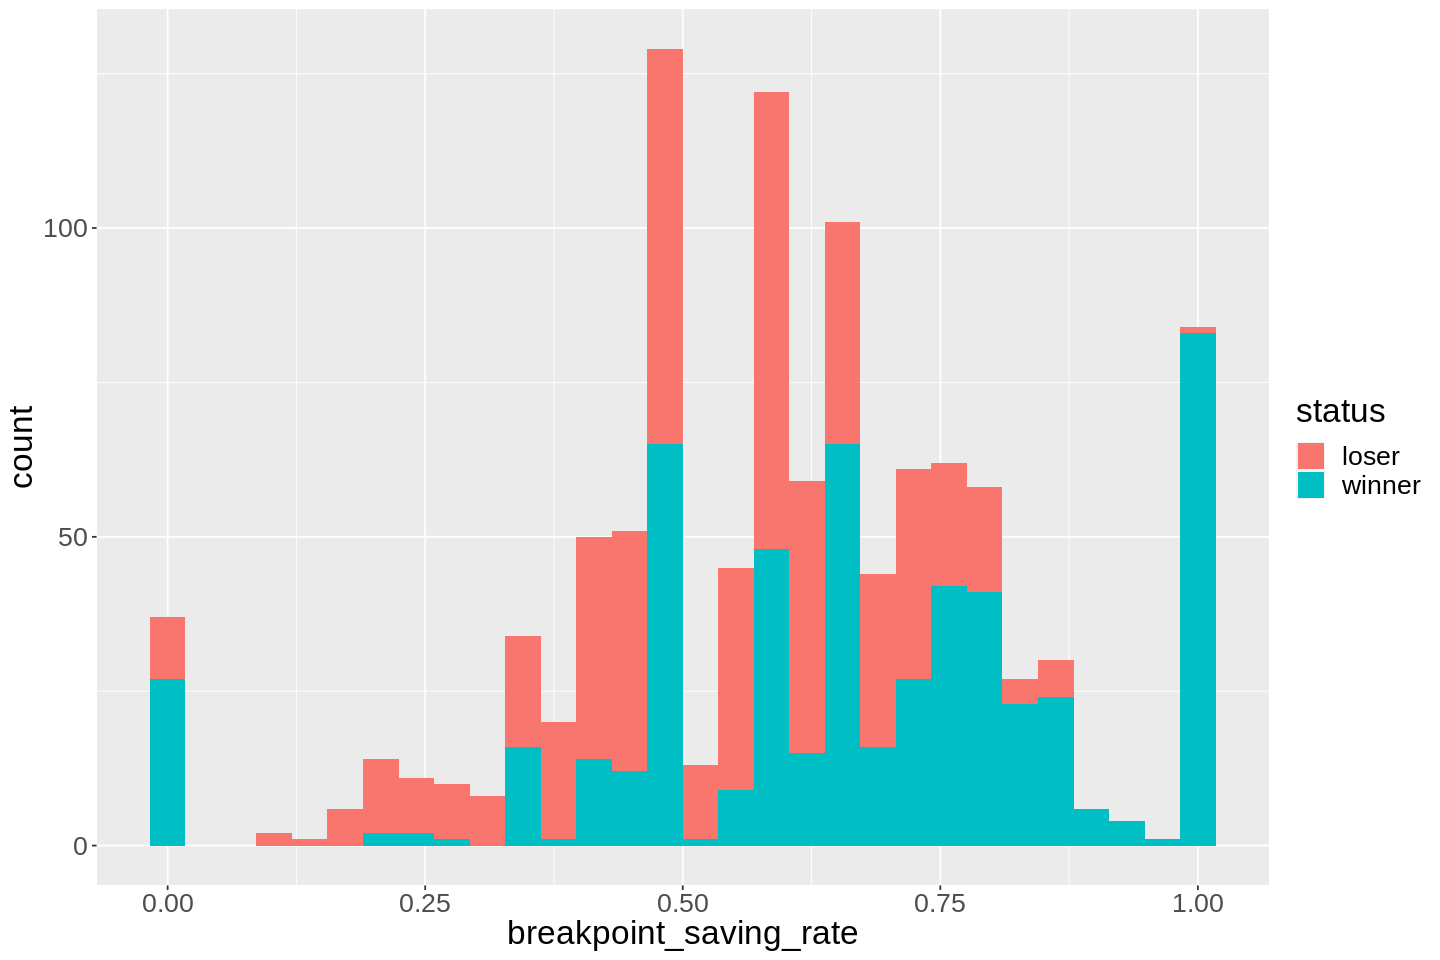

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



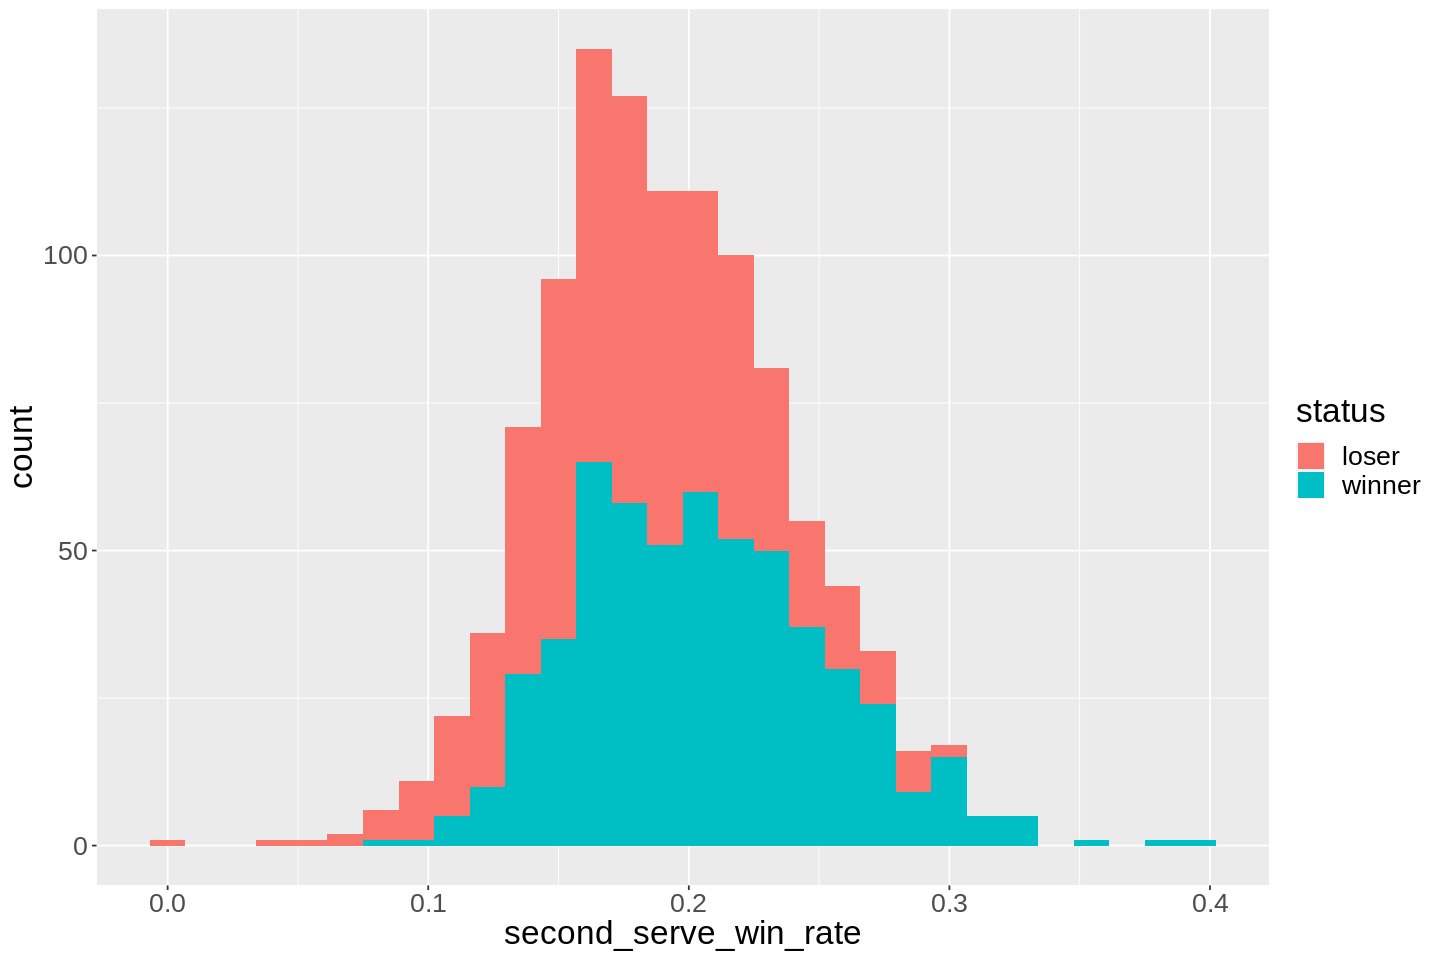

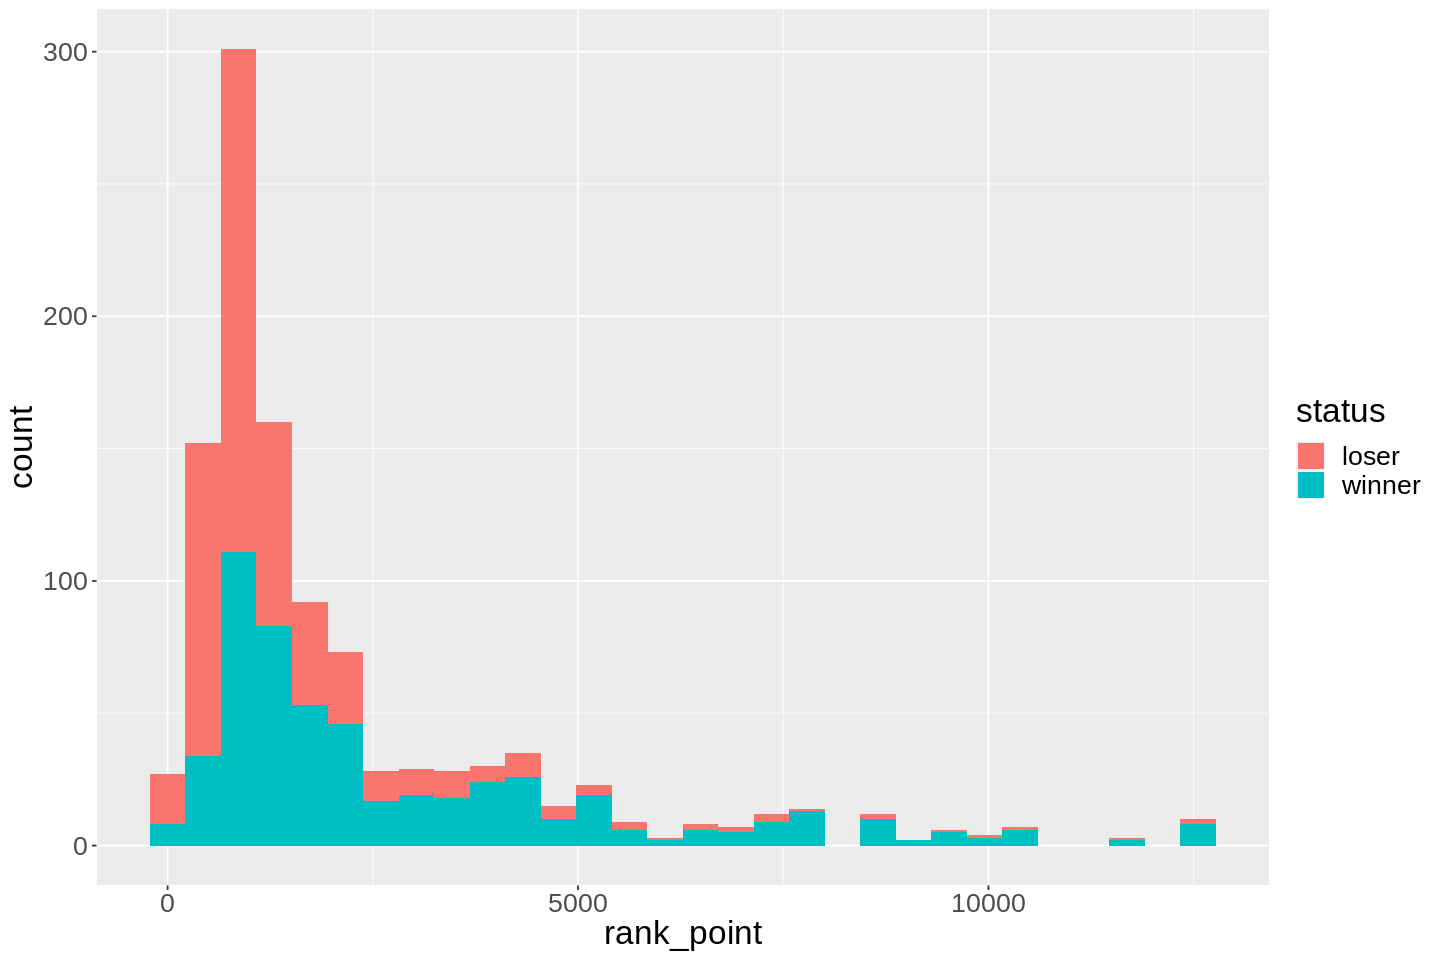

In [7]:
options(repr.plot.width = 12, repr.plot.height = 8) 
ggplot(stat_im_variable, aes(x = breakpoint_saving_rate , fill = status)) +
    geom_histogram() + 
    theme(text = element_text(size = 20))

ggplot(stat_im_variable, aes(x = second_serve_win_rate , fill = status)) +
    geom_histogram() + 
    theme(text = element_text(size = 20))

ggplot(stat_im_variable, aes(x = rank_point , fill = status)) +
    geom_histogram() + 
    theme(text = element_text(size = 20))

# Methods

Each winner and loser of a match will have their stats mutated into three percentage predictors which will be used to Classify whether or not that player was the Winner or Loser of the match. The first predictor calculates successful saved breakpoints while the second and third predictors calculate serves and whether or not that Player won a point on their second serve or received a double fault.

We can apply these values by using scatterplot graphs to compare the Winner and Loser stats for each match and visualize a trend. For example, we can compare the amount of points won on the second serve versus the number of double faults and have each point colored on whether or not that player won or lost the match.

# Expected outcomes and significance

We expect that if our created tennis player has superior stats to their opponent, they will be victorious. Conversely, if our player has inferior stats to the opponent, they will lose the match. These findings could be useful in predicting the outcomes of future or hypothetical tennis matches, given the competing players' past match histories. It could also be helpful in isolating certain stats that most strongly dictate the chances of victory, thus providing a better way of judging a player's skill.

Additionally, this model could pose the following questions/possibilities:
 - Is it possible to simulate entire tournaments with this model?
 - Can a player's career trajectory be predicted given their past statistics?
 - Are there other statistics that can prove more valuable in increasing the effectiveness of the model? 